# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.699520,True,5.566250
1,-0.230639,False,0.262511
2,0.607406,True,6.652147
3,-1.983378,False,-4.573683
4,-0.416633,True,4.424496
...,...,...,...
995,-0.715055,True,3.837009
996,-0.068381,True,3.753190
997,-1.522986,False,-2.130953
998,-1.238846,True,1.250435


<Axes: xlabel='v0'>

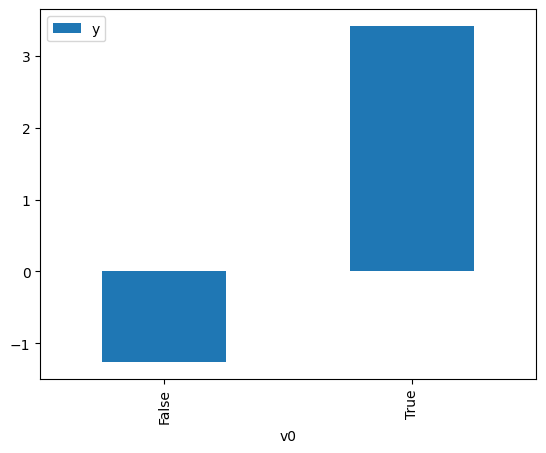

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

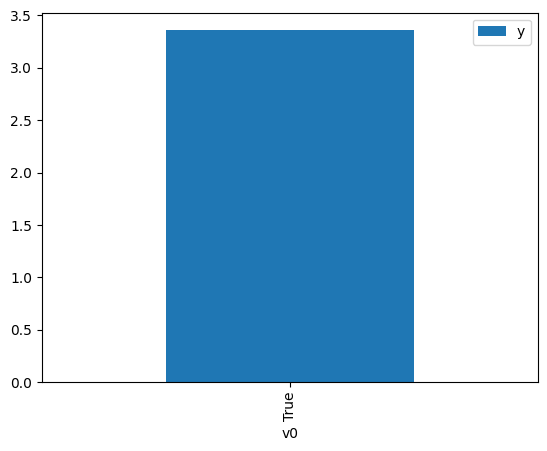

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.611460,False,2.125643,0.331875,3.013179
1,0.260684,False,1.608607,0.421643,2.371677
2,1.376295,False,4.569293,0.177074,5.647351
3,0.450122,False,1.034522,0.372094,2.687491
4,-0.723443,False,-1.037851,0.681443,1.467474
...,...,...,...,...,...
995,0.563489,False,1.095603,0.343611,2.910269
996,-0.594700,False,-0.691294,0.650126,1.538164
997,0.016123,False,-1.382704,0.487870,2.049728
998,-1.469151,False,-3.826766,0.828648,1.206786


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.944913,True,2.130353,0.268419,3.725515
1,0.265083,True,5.494562,0.579530,1.725535
2,1.101652,True,8.021155,0.774848,1.290576
3,-0.912506,True,4.163622,0.275437,3.630597
4,-0.307413,True,4.507873,0.424249,2.357107
...,...,...,...,...,...
995,-0.838680,True,3.927376,0.291841,3.426521
996,0.815720,True,5.448863,0.715681,1.397271
997,1.360879,True,8.034534,0.820455,1.218835
998,0.559810,True,6.787327,0.655481,1.525597


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              9734.
Date:                Sun, 16 Jul 2023   Prob (F-statistic):                        0.00
Time:                        17:17:40   Log-Likelihood:                         -1384.9
No. Observations:                1000   AIC:                                      2774.
Df Residuals:                     998   BIC:                                      2784.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4240      0.027     89.752      0.000       2.371       2.477
x2             5.0072      0.048    103.306      0.000       4.912       5.102
==============================================================================
Omnibus:                        1.388   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.500   Jarque-Bera (JB):                1.357
Skew:                           0.090   Prob(JB):                        0.507
Kurtosis:                       3.002   Cond. No.                         1.80
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""